<a href="https://colab.research.google.com/github/Noahbisht0/Tensorflow2-keras/blob/main/Tensorflow2_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-04-06 10:10:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2021-04-06 10:10:20 (39.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [ ]:
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("time")
  plt.ylabel("value")
  plt.grid(True)

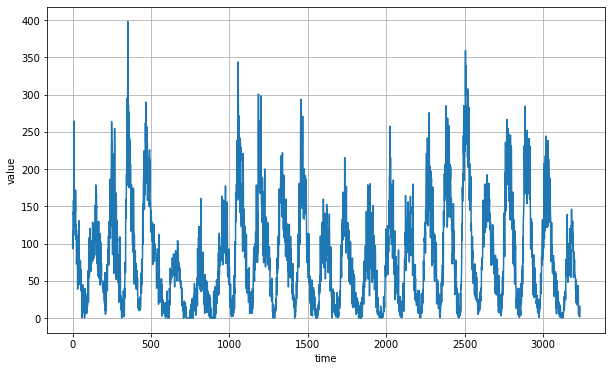

In [ ]:
import csv 
time_step = []
sunspots = []
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile,delimiter=",")
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [ ]:
split_time = 3000 
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30 
batch_size = 32 
shuffle_buffer_size = 3000

In [ ]:
def window_dataset(series,window_batch,batch_size,shuffle_buffer_size):
  series = tf.expand_dims(series,axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w : (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forcast(model,series,window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast 

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = window_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
print(train_set)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation="relu",input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(10,activation="relu"),
                                    tf.keras.layers.Dense(10,activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x : x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 **(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
Epoch 1/100
12/12 [==============================] - 8s 320ms/step - loss: 76.0265 - mae: 76.5236
Epoch 2/100
12/12 [==============================] - 4s 319ms/step - loss: 74.9814 - mae: 75.4783
Epoch 3/100
12/12 [==============================] - 5s 341ms/step - loss: 73.7558 - mae: 74.2531
Epoch 4/100
12/12 [==============================] - 5s 352ms/step - loss: 72.8077 - mae: 73.3050
Epoch 5/100
12/12 [==============================] - 5s 340ms/step - loss: 69.9335 - mae: 70.4303
Epoch 6/100
12/12 [==============================] - 5s 342ms/step - loss: 68.0688 - mae: 68.5653
Epoch 7/100
12/12 [==============================] - 5s 356ms/step - loss: 66.9487 - mae: 67.4458
Epoch 8/100
12/12 [==============================] - 5s 364ms/step - loss: 64.1817 - mae: 64.6784
Epoch 9/100
12/12 [==============================] - 5s 338ms/step - loss: 60.7496 - mae: 61.2461
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

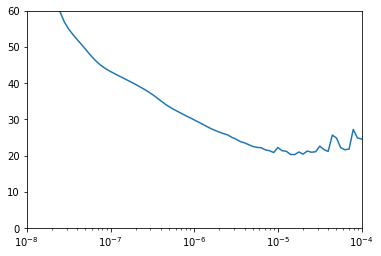

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#train_set = window_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer_size=shuffle_buffer_size)
train_set = window_dataset(x_train,60,100,shuffle_buffer_size=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 136ms/step - loss: 50.9234 - mae: 51.4205
Epoch 2/500
30/30 [==============================] - 4s 128ms/step - loss: 26.0556 - mae: 26.5502
Epoch 3/500
30/30 [==============================] - 4s 130ms/step - loss: 21.5741 - mae: 22.0674
Epoch 4/500
30/30 [==============================] - 4s 129ms/step - loss: 20.6802 - mae: 21.1731
Epoch 5/500
30/30 [==============================] - 4s 129ms/step - loss: 19.2090 - mae: 19.7014
Epoch 6/500
30/30 [==============================] - 4s 130ms/step - loss: 18.8019 - mae: 19.2939
Epoch 7/500
30/30 [==============================] - 4s 129ms/step - loss: 18.5186 - mae: 19.0108
Epoch 8/500
30/30 [==============================] - 4s 129ms/step - loss: 18.4671 - mae: 18.9591
Epoch 9/500
30/30 [==============================] - 4s 128ms/step - loss: 18.1826 - mae: 18.6746
Epoch 10/500
30/30 [==============================] - 4s 129ms/step - loss: 18.2360 - mae: 18.7278
Epoch 11/500
30/30 

In [ ]:
rnn_forcast = model_forcast(model,series[...,np.newaxis],window_size)
rnn_forcast = rnn_forcast[split_time - window_size: -1,-1,0]

In [ ]:
print(rnn_forcast.shape)
print(window_size)

(235,)
64


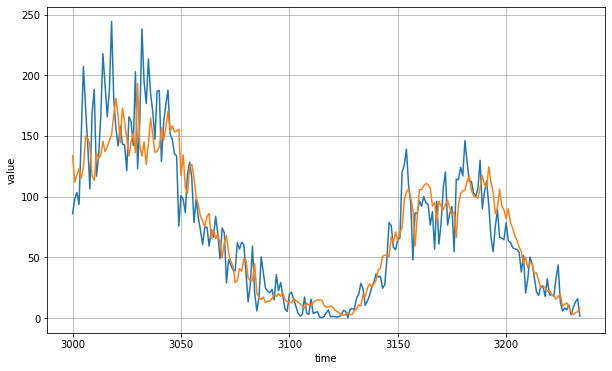

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forcast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forcast).numpy()

17.560064

<Figure size 432x288 with 0 Axes>

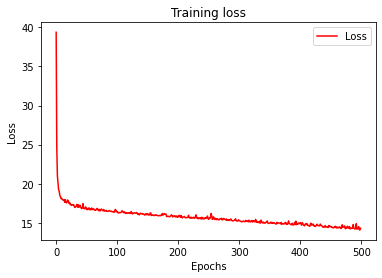

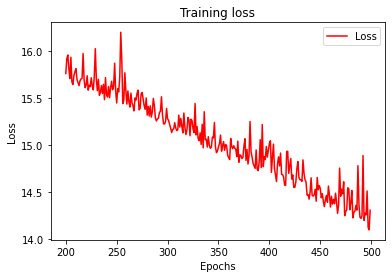

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forcast)

[133.763     111.95494   117.61432   122.840164  115.272285  123.78101
 149.69977   148.0706    142.02191   117.063835  113.36026   135.99857
 131.483     134.20705   145.61913   137.04195   140.86961   146.46936
 150.6789    167.51782   180.75633   166.94218   144.52254   173.06874
 161.53911   148.05045   133.34496   144.74493   152.31973   136.13713
 192.96921   141.97913   133.39328   145.04768   126.49205   143.85042
 164.74738   150.60675   136.36217   137.25565   140.93938   156.48048
 146.55493   156.46826   170.269     154.01315   158.38588   153.27501
 154.08119   155.49832   117.33064   134.40228   108.254715  102.39998
 124.64955   126.60513   115.48689    99.59709    93.53977    83.497925
  80.07845    75.017075   83.58709    86.040726   65.66297    72.447014
  65.286156   69.39801    61.754726   49.48552    62.413345   67.97297
  53.34375    46.577286   42.642555   29.232157   30.895365   40.63787
  38.637268   48.51018    47.919064   32.567623   30.949682   30.451233
  4